 19%|███████████████▌                                                                | 126/648 [00:11<00:42, 12.22it/s]


 40%|███████████████████████████████▊                                                | 258/648 [00:22<00:36, 10.70it/s]


 60%|████████████████████████████████████████████████▏                               | 390/648 [00:33<00:20, 12.30it/s]


 80%|████████████████████████████████████████████████████████████████                | 519/648 [00:45<00:11, 11.54it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:56<00:00, 11.50it/s]


1 (202, 354) 0.35427776225030144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.70s/it]


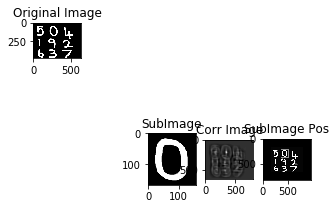

100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [00:09<00:00, 56.45it/s]


0 (282, 290) 0.07397570954368186


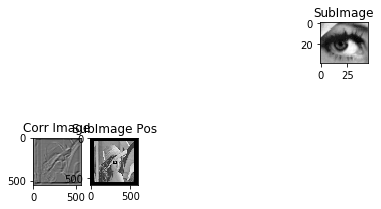

In [1]:
'''
2. 
    a. Consider the image the attached named as hdraw.png and crop each of the characters from the image and consider that as the sub-image. 
    Find the location of the sub-image in the original by using correlation.
    
    b. Download Lena color image convert it to grayscale image and crop the left eye of Lena as sub-image and 
    do the cross-correlation (Normalized correlation) to find the location of the left eye in the original image.
'''
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

def CrossCorrelation(I, W, stride=(1, 1), mean_mode='full'):
    I2 = I.copy()
    W = W.copy()
    if I.ndim == 2:
        I2 = np.reshape(I2, (I2.shape[0], I2.shape[1], 1))
        W = np.reshape(W, (W.shape[0], W.shape[1], 1))

    padSize = (I2.shape[0] + 2*(W.shape[0]-1), I2.shape[1] + 2*(W.shape[1]-1), I2.shape[2])
    I_padded = np.zeros(padSize)
    I_padded[W.shape[0]-1:-W.shape[0]+1, W.shape[1]-1:-W.shape[1]+1, :] = I2[:, :, :]

    outSize = (int((I2.shape[0] + W.shape[0])/stride[0]), int((I2.shape[1] + W.shape[1])/stride[1]), I2.shape[2])
    I_g = np.zeros(outSize)

    I_bar = None
    SDProd = np.ones(I2.shape[2])
    W_bar = np.sum(np.sum(W, axis=1), axis=0) / (W.shape[0]*W.shape[1])
    if mean_mode == 'full':
        I_bar = np.sum(np.sum(I2, axis=1), axis=0) / (I2.shape[0]*I2.shape[1])
        for c in range(I2.shape[2]):
            SDProd[c] = np.sum(np.sum((I2[:, :, c] - I_bar)**2, axis=1), axis=0) ** (1/2)
            SDProd[c] *= np.sum(np.sum((W[:, :, c] - W_bar)**2, axis=1), axis=0) ** (1/2)
            #SDProd[c] = np.std(I2[:, :, c].flatten()) * np.std(W[:, :, c].flatten())

    for i in tqdm(range(0, I_padded.shape[0]-W.shape[0]+1, stride[0])):
        for j in range(0, I_padded.shape[1]-W.shape[1]+1, stride[1]):
            if mean_mode == 'window':
                I_bar = np.sum(np.sum(I_padded[i:i+W.shape[0], j:j+W.shape[1], :], axis=1), axis=0) / (W.shape[0]*W.shape[1])
            for c in range(I_padded.shape[2]):
                if mean_mode == 'window':
                    SDProd[c] = np.sum(np.sum((I_padded[i:i+W.shape[0], j:j+W.shape[1], c] - I_bar)**2, axis=1), axis=0) ** (1/2)
                    SDProd[c] *= np.sum(np.sum((W[:, :, c] - W_bar)**2, axis=1), axis=0) ** (1/2)
                    #SDProd[c] = np.std(I_padded[i:i+W.shape[0], j:j+W.shape[1], c].flatten()) * np.std(W[:, :, c].flatten())
                I_val = I_padded[i:i+W.shape[0], j:j+W.shape[1], c] - I_bar[c]
                W_val = W[:, :, c] - W_bar[c]
                I_g[i, j, c] = np.sum(np.sum(np.multiply(I_val, W_val), axis=1), axis=0) / SDProd[c]
            
    if I.ndim == 2:
        I_g = np.reshape(I_g, (I_g.shape[0], I_g.shape[1]))
        I_padded = np.reshape(I_padded, (I_padded.shape[0], I_padded.shape[1]))
        W = np.reshape(W, (W.shape[0], W.shape[1]))
    return I_g, I_padded

def Correlation(I, W, stride=(1, 1)):
    I2 = I.copy()
    W = W.copy()
    if I.ndim == 2:
        I2 = np.reshape(I2, (I2.shape[0], I2.shape[1], 1))
        W = np.reshape(W, (W.shape[0], W.shape[1], 1))

    padSize = (I2.shape[0] + 2*(W.shape[0]-1), I2.shape[1] + 2*(W.shape[1]-1), I2.shape[2])
    I_padded = np.zeros(padSize)
    I_padded[W.shape[0]-1:-W.shape[0]+1, W.shape[1]-1:-W.shape[1]+1, :] = I2[:, :, :]

    outSize = (int((I2.shape[0] + W.shape[0])/stride[0]), int((I2.shape[1] + W.shape[1])/stride[1]), I2.shape[2])
    I_g = np.zeros(outSize)

    for i in tqdm(range(0, I_padded.shape[0]-W.shape[0]+1, stride[0])):
        for j in range(0, I_padded.shape[1]-W.shape[1]+1, stride[1]):
            for c in range(I_padded.shape[2]):
                I_g[i, j, c] = np.sum(np.sum(np.multiply(I_padded[i:i+W.shape[0], j:j+W.shape[1], c], W[:, :, c]), axis=1), axis=0)
            
    if I.ndim == 2:
        I_g = np.reshape(I_g, (I_g.shape[0], I_g.shape[1]))
        I_padded = np.reshape(I_padded, (I_padded.shape[0], I_padded.shape[1]))
        W = np.reshape(W, (W.shape[0], W.shape[1]))
    return I_g, I_padded
    
def BoundingBox(Image, pos, window_size, radius=1, color=[0, 0, 0]):
    I = Image.copy()
    window_size = [window_size[0], window_size[1]]
    for wi in range(len(window_size)):
        if pos[wi] + window_size[wi] > Image.shape[wi]:
            window_size[wi] = Image.shape[wi] - pos[wi]
    
    if I.ndim == 2:
        for i in [pos[0], pos[0] + window_size[0]]:
            for p in range(pos[1], pos[1] + window_size[1]):
                I[i, p] = color[0]
                #print("Markx:", i, p, color[0])
        for j in [pos[1], pos[1] + window_size[1]]:
            for p in range(pos[0], pos[0] + window_size[0]):
                I[p, j] = color[0]
                #print("Marky:", p, j, color[0])
    elif I.ndim == 3:
        for i in [pos[0], pos[0] + window_size[0]]:
            for p in range(pos[1], pos[1] + window_size[1]):
                I[i, p, :] = color[:I.shape[2]]
        for j in [pos[1], pos[1] + window_size[1]]:
            for p in range(pos[0], pos[0] + window_size[0]):
                I[p, j, :] = color[:I.shape[2]]

    for ri in range(1, radius+1):
        I = BoundingBox(I, [pos[0]+ri, pos[1]+ri], [window_size[0]-(2*ri), window_size[1]-(2*ri)], radius=0, color=color)
    return I

def ceil(a):
    if (a-float(int(a))) > 0:
        return a + 1
    return a

def NormaliseToRange(I, Range=(0, 255)):
    I_g = I.copy()
    if I.ndim == 2:
        I_g = np.reshape(I_g, (I_g.shape[0], I_g.shape[1], 1))
    
    maxVal = np.max(np.max(I_g, axis=1), axis=0)
    minVal = np.min(np.min(I_g, axis=1), axis=0)

    minmaxRange = maxVal - minVal

    for i in range(I_g.shape[0]):
        for j in range(I_g.shape[1]):
            for c in range(I_g.shape[2]):
                I_g[i, j, c] = (((I_g[i, j, c] - minVal[c]) / minmaxRange) * (Range[1] - Range[0])) + Range[0]

    if I.ndim == 2:
        I_g = np.reshape(I_g, (I_g.shape[0], I_g.shape[1]))

    return I_g


# Driver Code
main_path = ''
nCols = 6
img_path = os.path.join(main_path, 'hdraw.png')
subimgs_names = ['0']#, '1', '2', '3', '4', '5', '6', '7', '9']
nOps = 3

I_main = cv2.imread(img_path, 0)
ax = plt.subplot(1 + ceil(nOps*len(subimgs_names)/(nCols)), nCols, 1)
ax.title.set_text('Original Image')
plt.imshow(I_main, 'gray')

SubImgs = []
spindex = 0
for sp in tqdm(subimgs_names):
    spindex += 1
    SubImgs.append(cv2.imread(os.path.join(main_path, sp + '.png'), 0))
    Window = SubImgs[-1]
    I_cor, I_padded = CrossCorrelation(I_main, Window)

    maxPos = (0, 0)
    for i in range(I_cor.shape[0]):
        for j in range(I_cor.shape[1]):
            if I_cor[maxPos[0], maxPos[1]] < I_cor[i, j]:
                maxPos = (i, j)
    print(spindex, maxPos, I_cor[maxPos[0], maxPos[1]])
    I_boundbox = BoundingBox(I_padded, maxPos, Window.shape, radius=10, color=[150, 150, 150])

    ax = plt.subplot(1 + ceil(nOps*len(subimgs_names)/(nCols)), nCols, nCols + nOps*spindex)
    ax.title.set_text('SubImage')
    plt.imshow(SubImgs[-1], 'gray')
    ax = plt.subplot(1 + ceil(nOps*len(subimgs_names)/(nCols)), nCols, nCols + nOps*spindex+1)
    ax.title.set_text('Corr Image')
    plt.imshow(NormaliseToRange(I_cor).astype(np.uint8), 'gray')
    ax = plt.subplot(1 + ceil(nOps*len(subimgs_names)/(nCols)), nCols, nCols + nOps*spindex+2)
    ax.title.set_text('SubImage Pos')
    plt.imshow(I_boundbox, 'gray')

plt.show()

# B
img_path = os.path.join(main_path, 'LenaImage.png')
subImg_path = os.path.join(main_path, 'LenaImage_LeftEye.png')
I = cv2.imread(img_path, 0)
Window = cv2.imread(subImg_path, 0)
I_cor, I_padded = CrossCorrelation(I, Window)
maxPos = (0, 0)

spindex = 0
for i in range(I_cor.shape[0]):
    for j in range(I_cor.shape[1]):
        if I_cor[maxPos[0], maxPos[1]] < I_cor[i, j]:
            maxPos = (i, j)
print(spindex, maxPos, I_cor[maxPos[0], maxPos[1]])
I_boundbox = BoundingBox(I_padded, maxPos, Window.shape, radius=10, color=[0, 0, 0])

ax = plt.subplot(1 + 1, nCols, nCols + spindex)
ax.title.set_text('SubImage')
plt.imshow(Window, 'gray')
ax = plt.subplot(1 + 1, nCols, nCols + spindex+1)
ax.title.set_text('Corr Image')
plt.imshow(NormaliseToRange(I_cor).astype(np.uint8), 'gray')
ax = plt.subplot(1 + 1, nCols, nCols + spindex+2)
ax.title.set_text('SubImage Pos')
plt.imshow(I_boundbox, 'gray')

plt.show()